In [ ]:
import pandas as pd
import numpy as np

Import data

In [ ]:
cusDemo = pd.read_excel("/content/KPMG_VI_New_raw_data_update_final.xlsx", "CustomerDemographic", skiprows=1)
cusAdr = pd.read_excel("/content/KPMG_VI_New_raw_data_update_final.xlsx", "CustomerAddress", skiprows=1)
tra = pd.read_excel("/content/KPMG_VI_New_raw_data_update_final.xlsx", "Transactions", skiprows=1)
newCus = pd.read_excel("/content/KPMG_VI_New_raw_data_update_final.xlsx", "NewCustomerList", skiprows=1)

In [ ]:
# dropping duplicate rows
cusDemo.drop_duplicates()
cusAdr.drop_duplicates()
tra.drop_duplicates()
newCus.drop_duplicates()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,14,45 Shopko Center,4500,QLD,Australia,6,0.93,1.1625,1.453125,1.235156,1,1,1.718750
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,16,14 Mccormick Park,2113,NSW,Australia,11,0.70,0.7000,0.875000,0.743750,1,1,1.718750
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,10,5 Colorado Crossing,3505,VIC,Australia,5,0.95,0.9500,0.950000,0.950000,1,1,1.718750
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,5,207 Annamark Plaza,4814,QLD,Australia,1,0.54,0.6750,0.675000,0.675000,4,4,1.703125
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,19,115 Montana Place,2093,NSW,Australia,9,0.52,0.5200,0.650000,0.650000,4,4,1.703125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Ferdinand,Romanetti,Male,60,1959-10-07,Paralegal,Financial Services,Affluent Customer,N,No,9,2 Sloan Way,2200,NSW,Australia,7,1.09,1.0900,1.090000,1.090000,996,996,0.374000
996,Burk,Wortley,Male,22,2001-10-17,Senior Sales Associate,Health,Mass Customer,N,No,6,04 Union Crossing,2196,NSW,Australia,10,0.42,0.4200,0.525000,0.446250,997,997,0.357000
997,Melloney,Temby,Female,17,1954-10-05,Budget/Accounting Analyst IV,Financial Services,Affluent Customer,N,Yes,15,33475 Fair Oaks Junction,4702,QLD,Australia,2,0.43,0.5375,0.537500,0.537500,997,997,0.357000
998,Dickie,Cubbini,Male,30,1952-12-17,Financial Advisor,Financial Services,Mass Customer,N,Yes,19,57666 Victoria Way,4215,QLD,Australia,2,0.66,0.8250,0.825000,0.701250,997,997,0.357000


In [ ]:
# Data exploration is done in tableau

In [ ]:
# to group products, first will clean the data
transClean = tra.drop(['transaction_id', 'transaction_date'],1)

In [ ]:
# convert categorical value to numerical

# convert to binary
from sklearn.preprocessing import label_binarize
transClean["order_status"] = label_binarize(transClean["order_status"], classes=["Approved", "Cancelled"])

In [ ]:
transClean.dropna(inplace=True)

In [ ]:
# convert to LabelEncoder 
transClean['product_class'] = transClean['product_class'].apply(lambda x: ['low', 'medium', 'high'].index(x))

transClean['product_size'] = transClean['product_size'].apply(lambda x: ['small', 'medium', 'large'].index(x))

In [ ]:
# convert to one-hot encoding
transClean = pd.concat([transClean.drop('brand', axis=1), pd.get_dummies(transClean["brand"], prefix="brand")], axis=1)
transClean = pd.concat([transClean.drop('product_line', axis=1), pd.get_dummies(transClean["product_line"], prefix="product_line")], axis=1)

In [ ]:
transClean

,product_id,customer_id,online_order,order_status,product_class,product_size,list_price,standard_cost,product_first_sold_date,brand_Giant Bicycles,brand_Norco Bicycles,brand_OHM Cycles,brand_Solex,brand_Trek Bicycles,brand_WeareA2B,product_line_Mountain,product_line_Road,product_line_Standard,product_line_Touring
0,2,2950,0.0,0,1,1,71.49,53.62,41245.0,0,0,0,1,0,0,0,0,1,0
1,3,3120,1.0,0,1,2,2091.47,388.92,41701.0,0,0,0,0,1,0,0,0,1,0
2,37,402,0.0,0,0,1,1793.43,248.82,36361.0,0,0,1,0,0,0,0,0,1,0
3,88,3135,0.0,0,1,1,1198.46,381.10,36145.0,0,1,0,0,0,0,0,0,1,0
4,78,787,1.0,0,1,2,1765.30,709.48,42226.0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,51,1018,1.0,0,2,1,2005.66,1203.40,37823.0,0,0,1,0,0,0,0,0,1,0
19996,41,127,1.0,0,1,1,416.98,312.74,35560.0,0,0,0,1,0,0,0,1,0,0
19997,87,2284,1.0,0,1,1,1636.90,44.71,40410.0,0,0,1,0,0,0,0,0,1,0
19998,6,2764,0.0,0,2,1,227.88,136.73,38216.0,0,0,1,0,0,0,0,0,1,0


In [ ]:
# scaling before modelling ( data transformataion)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_prodInfo = transClean.drop([ 'product_id', 'customer_id'],1)
scaled_prodInfo = scaler.fit_transform(scaled_prodInfo)

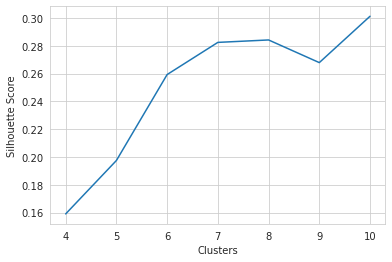

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
cluster_nums = [4,5,6,7,8,9,10]
scores = []
for cluster_num in cluster_nums:
    kmeans = KMeans(cluster_num)
    kmeans.fit(scaled_prodInfo)
    clusters = kmeans.predict(scaled_prodInfo)
    silhouette = silhouette_score(scaled_prodInfo, clusters)
    scores.append(silhouette)
  
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
plt.ylabel('Silhouette Score')
plt.xlabel('Clusters')
sns.lineplot(x=cluster_nums,y=scores)

In [ ]:
# model building to cluster the products - using k mean with k = 8
from sklearn.cluster import KMeans
kmeansProd = KMeans(8)
kmeansProd.fit(scaled_prodInfo)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
transClean['ProductGrp'] = kmeansProd.labels_

In [ ]:
np.unique(kmeansProd.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [ ]:
# find profit
transClean["profit"] = transClean["list_price"] - transClean["standard_cost"]

In [ ]:
transClean

,product_id,customer_id,online_order,order_status,product_class,product_size,list_price,standard_cost,product_first_sold_date,brand_Giant Bicycles,brand_Norco Bicycles,brand_OHM Cycles,brand_Solex,brand_Trek Bicycles,brand_WeareA2B,product_line_Mountain,product_line_Road,product_line_Standard,product_line_Touring,ProductGrp,profit
0,2,2950,0.0,0,1,1,71.49,53.62,41245.0,0,0,0,1,0,0,0,0,1,0,2,17.87
1,3,3120,1.0,0,1,2,2091.47,388.92,41701.0,0,0,0,0,1,0,0,0,1,0,7,1702.55
2,37,402,0.0,0,0,1,1793.43,248.82,36361.0,0,0,1,0,0,0,0,0,1,0,0,1544.61
3,88,3135,0.0,0,1,1,1198.46,381.10,36145.0,0,1,0,0,0,0,0,0,1,0,1,817.36
4,78,787,1.0,0,1,2,1765.30,709.48,42226.0,1,0,0,0,0,0,0,0,1,0,5,1055.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,51,1018,1.0,0,2,1,2005.66,1203.40,37823.0,0,0,1,0,0,0,0,0,1,0,0,802.26
19996,41,127,1.0,0,1,1,416.98,312.74,35560.0,0,0,0,1,0,0,0,1,0,0,2,104.24
19997,87,2284,1.0,0,1,1,1636.90,44.71,40410.0,0,0,1,0,0,0,0,0,1,0,0,1592.19
19998,6,2764,0.0,0,2,1,227.88,136.73,38216.0,0,0,1,0,0,0,0,0,1,0,0,91.15


# cluster customer based on demographic

In [ ]:
# filter customer who is not did any tranaction/purchase
index = cusDemo.customer_id.isin(transClean.customer_id)
cusDemoImp = cusDemo[index]

In [ ]:
cusDemoImp.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# add customer Address data to cusDemoImp 
# cusDemoImp = pd.concat(cusDemoImp, cusAdr[~cusAdr.customer_id.isin(cusDemoImp.customer_id)])
cusDemoImp["property_valuation"] = cusAdr[cusAdr.customer_id.isin(cusDemoImp.customer_id)].property_valuation
cusDemoImp["state"] = cusAdr[cusAdr.customer_id.isin(cusDemoImp.customer_id)].state

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
cusDemoImp = cusDemoImp.drop(["deceased_indicator", "first_name", "last_name", "default"], axis=1)
cusDemoImp.dropna(inplace=True)
cusDemoImp = cusDemoImp[cusDemoImp.gender != "U"]

In [ ]:
cusDemoImp


,customer_id,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,owns_car,tenure,property_valuation,state
1,66,Male,46,2002-03-11,Account Executive,Argiculture,High Net Worth,No,1.0,10.0,New South Wales
9,1402,Male,58,2001-12-08,Assistant Professor,Telecommunications,Mass Customer,No,1.0,4.0,QLD
10,1519,Male,35,2001-11-30,Administrative Assistant IV,Telecommunications,High Net Worth,Yes,1.0,6.0,VIC
11,212,Female,21,2001-11-19,Desktop Support Technician,IT,Affluent Customer,No,1.0,8.0,New South Wales
12,2759,Female,16,2001-11-14,Operator,Health,Affluent Customer,Yes,1.0,9.0,New South Wales
...,...,...,...,...,...,...,...,...,...,...,...
3483,2239,Female,0,1960-01-11,Associate Professor,Property,High Net Worth,Yes,8.0,10.0,NSW
3487,1104,Female,82,1959-12-31,Programmer III,Retail,Mass Customer,No,8.0,9.0,VIC
3488,3418,Female,18,1959-12-31,Systems Administrator IV,Health,High Net Worth,No,19.0,10.0,NSW
3489,2416,Male,19,1959-12-29,Office Assistant I,Health,Affluent Customer,No,16.0,10.0,NSW


In [ ]:
# convert categarical variable into numerical
cusDemoImp.owns_car = cusDemoImp.owns_car.apply(lambda x: 1 if x == "Yes" else 0)

In [ ]:
cusDemoImp.gender = cusDemoImp.gender.apply(lambda x: 1 if x == "Male" else 0)

In [ ]:
# find age
from datetime import datetime as dt
now = dt.now()
cusDemoImp['age'] =  now.year - cusDemoImp['DOB'].dt.year # 

In [ ]:
cusDemoImp.drop(["DOB","job_title"], axis=1, inplace=True)

In [ ]:
# one hot encoding
#cusDemoImp = pd.concat([cusDemoImp.drop('job_title', axis=1), pd.get_dummies(cusDemoImp["job_title"], prefix="job_title")], axis=1)
cusDemoImp = pd.concat([cusDemoImp.drop('job_industry_category', axis=1), pd.get_dummies(cusDemoImp["job_industry_category"], prefix="job_industry_category")], axis=1)
cusDemoImp = pd.concat([cusDemoImp.drop('wealth_segment', axis=1), pd.get_dummies(cusDemoImp["wealth_segment"], prefix="wealth_segment")], axis=1)
cusDemoImp = pd.concat([cusDemoImp.drop('state', axis=1), pd.get_dummies(cusDemoImp["state"], prefix="state")], axis=1)

In [ ]:
cusDemoImp

,customer_id,gender,past_3_years_bike_related_purchases,owns_car,tenure,property_valuation,age,job_industry_category_Argiculture,job_industry_category_Entertainment,job_industry_category_Financial Services,job_industry_category_Health,job_industry_category_IT,job_industry_category_Manufacturing,job_industry_category_Property,job_industry_category_Retail,job_industry_category_Telecommunications,wealth_segment_Affluent Customer,wealth_segment_High Net Worth,wealth_segment_Mass Customer,state_NSW,state_New South Wales,state_QLD,state_VIC,state_Victoria
1,66,1,46,0,1.0,10.0,18,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
9,1402,1,58,0,1.0,4.0,19,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
10,1519,1,35,1,1.0,6.0,19,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
11,212,0,21,0,1.0,8.0,19,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
12,2759,0,16,1,1.0,9.0,19,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3483,2239,0,0,1,8.0,10.0,60,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
3487,1104,0,82,0,8.0,9.0,61,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
3488,3418,0,18,0,19.0,10.0,61,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
3489,2416,1,19,0,16.0,10.0,61,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0


In [ ]:
# scale data
scaled_cusDemoImp = cusDemoImp.drop("customer_id", axis=1)
scaled_cusDemoImp = scaler.fit_transform(scaled_cusDemoImp)

In [ ]:
scaled_cusDemoImp

array([[ 1.04512412, -0.1158979 , -1.05578355, ..., -0.51846633,
        -0.5419709 , -0.14890584],
       [ 1.04512412,  0.3023325 , -1.05578355, ...,  1.92876554,
        -0.5419709 , -0.14890584],
       [ 1.04512412, -0.49927577,  0.94716384, ..., -0.51846633,
         1.8451175 , -0.14890584],
       ...,
       [-0.95682416, -1.09176884, -1.05578355, ..., -0.51846633,
        -0.5419709 , -0.14890584],
       [ 1.04512412, -1.05691631, -1.05578355, ..., -0.51846633,
        -0.5419709 , -0.14890584],
       [-0.95682416, -0.25530804, -1.05578355, ..., -0.51846633,
        -0.5419709 , -0.14890584]])

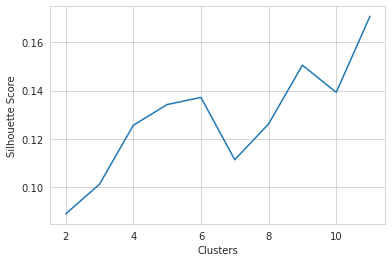

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
cluster_nums = [2,3,4,5,6,7,8,9,10,11]
scores = []
for cluster_num in cluster_nums:
    kmeans = KMeans(cluster_num)
    kmeans.fit(scaled_cusDemoImp)
    clusters = kmeans.predict(scaled_cusDemoImp)
    silhouette = silhouette_score(scaled_cusDemoImp, clusters)
    scores.append(silhouette)
  
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
plt.ylabel('Silhouette Score')
plt.xlabel('Clusters')
sns.lineplot(x=cluster_nums,y=scores)

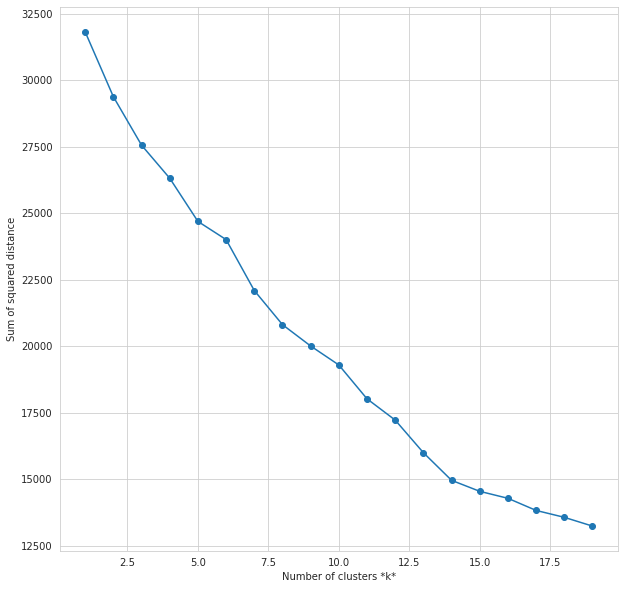

In [ ]:
# Run the Kmeans algorithm and get the index of data points clusters (elbow method)
sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(scaled_cusDemoImp)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(10, 10))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [ ]:
# k-mean with k = 6
from sklearn.cluster import KMeans
kmeans_cus = KMeans(6)
kmeans_cus.fit(scaled_cusDemoImp)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
cusDemoImp["cluster"]= kmeans_cus.labels_

In [ ]:
np.unique(kmeans_cus.labels_)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [ ]:
# create number of customer cluster X number of product cluster
analysisMtx = pd.DataFrame(index=range(0,6))
for index in range(0,8):
  analysisMtx["product" + str(index)] = 0.0

In [ ]:
cusDemoImp[cusDemoImp.customer_id == 66].cluster

1    1
Name: cluster, dtype: int32

In [ ]:
# fill matrix with purchase cost
for indexProd in transClean.index:
  customerId = transClean.loc[indexProd, "customer_id"]
  ProductGrp = transClean.loc[indexProd, "ProductGrp"]
  profit = transClean.loc[indexProd, "profit"]

  #use customer cluster number of customer id in index place
  analysisMtx.loc[cusDemoImp[cusDemoImp.customer_id == customerId].cluster, "product" + str(ProductGrp)] += profit

In [ ]:
analysisMtx

,product0,product1,product2,product3,product4,product5,product6,product7
0,94484.50,57517.87,132467.35,115799.43,145525.98,105449.01,2972.52,137059.59
1,30060.40,17641.14,39150.76,14436.84,47514.91,31249.40,762.72,28635.07
2,122363.05,66429.21,188082.57,123511.94,163605.20,99127.50,4239.36,144651.32
3,49770.12,27049.84,72642.62,39333.12,80356.08,43024.60,1447.08,63104.97
4,128644.92,76709.65,208392.85,129613.16,157091.47,120603.82,3087.45,179775.02
5,111787.74,64776.63,177712.50,103370.23,147425.03,113840.63,3507.99,173592.18
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
# statistic
analysisMtx["count"] = 0.0
analysisMtx["mean"] = 0.0
analysisMtx["min"] = 10000.0
analysisMtx["max"] = 0.0
analysisMtx["sum"] = 0.0

In [ ]:
#grouped= transClean.groupby('customer_id')

In [ ]:
#grouped.head()

In [ ]:
for stIndex in cusDemoImp.index:
  customer_id = cusDemoImp.loc[stIndex, "customer_id"]
  histStat = transClean[transClean.customer_id == customer_id].profit
  cluster = cusDemoImp.loc[stIndex, "cluster"]
  analysisMtx.loc[cluster, "count"] += histStat.count()
  analysisMtx.loc[cluster, "max"] = max(analysisMtx.loc[cluster, "max"], histStat.sum())
  analysisMtx.loc[cluster, "min"] = min(analysisMtx.loc[cluster, "min"], histStat.sum())
  analysisMtx.loc[cluster, "sum"] += histStat.sum()

for stIndex in analysisMtx.index:
  analysisMtx.loc[stIndex, "mean"] = analysisMtx.loc[stIndex, "sum"] / analysisMtx.loc[stIndex, "count"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
cusDemoImp

,customer_id,gender,past_3_years_bike_related_purchases,owns_car,tenure,property_valuation,age,job_industry_category_Argiculture,job_industry_category_Entertainment,job_industry_category_Financial Services,job_industry_category_Health,job_industry_category_IT,job_industry_category_Manufacturing,job_industry_category_Property,job_industry_category_Retail,job_industry_category_Telecommunications,wealth_segment_Affluent Customer,wealth_segment_High Net Worth,wealth_segment_Mass Customer,state_NSW,state_New South Wales,state_QLD,state_VIC,state_Victoria,cluster
1,66,1,46,0,1.0,10.0,18,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
9,1402,1,58,0,1.0,4.0,19,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
10,1519,1,35,1,1.0,6.0,19,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,5
11,212,0,21,0,1.0,8.0,19,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
12,2759,0,16,1,1.0,9.0,19,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3483,2239,0,0,1,8.0,10.0,60,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,3
3487,1104,0,82,0,8.0,9.0,61,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,5
3488,3418,0,18,0,19.0,10.0,61,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,4
3489,2416,1,19,0,16.0,10.0,61,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,4


In [ ]:
analysisMtx

,product0,product1,product2,product3,product4,product5,product6,product7,count,mean,min,max,sum
0,94484.50,57517.87,132467.35,115799.43,145525.98,105449.01,2972.52,137059.59,1400.0,565.197321,79.16,11222.65,791276.25
1,30060.40,17641.14,39150.76,14436.84,47514.91,31249.40,762.72,28635.07,373.0,561.531475,167.63,8321.81,209451.24
2,122363.05,66429.21,188082.57,123511.94,163605.20,99127.50,4239.36,144651.32,1645.0,554.413465,50.18,8834.60,912010.15
3,49770.12,27049.84,72642.62,39333.12,80356.08,43024.60,1447.08,63104.97,678.0,555.646652,128.46,8499.59,376728.43
4,128644.92,76709.65,208392.85,129613.16,157091.47,120603.82,3087.45,179775.02,1880.0,533.999117,89.71,11668.95,1003918.34
5,111787.74,64776.63,177712.50,103370.23,147425.03,113840.63,3507.99,173592.18,1627.0,550.714770,50.66,8252.73,896012.93
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,NaN,10000.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,NaN,10000.00,0.00,0.00


In [ ]:
analysisMtx.to_csv("productCustomerAnalysis.csv")

# Group new customers into 8 cluster, then recommend product group to each customer group

In [ ]:
newCus.drop(["first_name", "last_name", "job_title","deceased_indicator", "address","postcode","country","Rank","Value","Unnamed: 16","Unnamed: 18","Unnamed: 17","Unnamed: 19","Unnamed: 20"], axis=1, inplace=True)

In [ ]:
# clean new customer dataset
newCustImp = newCus
# find age
from datetime import datetime as dt
now = dt.now()
newCustImp['age'] =  now.year - newCustImp['DOB'].dt.year # 

# convert categarical variable into numerical
newCustImp.owns_car = newCustImp.owns_car.apply(lambda x: 1 if x == "Yes" else (0 if x=="No" else None))
newCustImp.gender = newCustImp.gender.apply(lambda x: 1 if x == "Male" else (0 if x=="Female" else None))



In [ ]:
newCustVis  = newCustImp

In [ ]:
# one hot encoding
newCustImp = pd.concat([newCustImp.drop('job_industry_category', axis=1), pd.get_dummies(newCustImp["job_industry_category"], prefix="job_industry_category")], axis=1)
newCustImp = pd.concat([newCustImp.drop('wealth_segment', axis=1), pd.get_dummies(newCustImp["wealth_segment"], prefix="wealth_segment")], axis=1)
newCustImp = pd.concat([newCustImp.drop('state', axis=1), pd.get_dummies(newCustImp["state"], prefix="state")], axis=1)

In [ ]:
newCustImp.dropna(inplace=True)
newCustImp.drop(["DOB"],axis=1, inplace=True)

In [ ]:
newCustImp["state_New South Wales"] = 0 
newCustImp["state_Victoria"] = 0 

In [ ]:
cusDemoImp.head(3)

,customer_id,gender,past_3_years_bike_related_purchases,owns_car,tenure,property_valuation,age,job_industry_category_Argiculture,job_industry_category_Entertainment,job_industry_category_Financial Services,job_industry_category_Health,job_industry_category_IT,job_industry_category_Manufacturing,job_industry_category_Property,job_industry_category_Retail,job_industry_category_Telecommunications,wealth_segment_Affluent Customer,wealth_segment_High Net Worth,wealth_segment_Mass Customer,state_NSW,state_New South Wales,state_QLD,state_VIC,state_Victoria,cluster
1,66,1,46,0,1.0,10.0,18,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
9,1402,1,58,0,1.0,4.0,19,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
10,1519,1,35,1,1.0,6.0,19,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,5


In [ ]:
# scale values
scaled_newCustImp = scaler.fit_transform(newCustImp)

In [ ]:
# clustering new clusters using customer clustering model
newCustImp["cluster"]=kmeans_cus.predict(scaled_newCustImp)

In [ ]:
# convert back to categarical variable from numerical
newCustVis.owns_car = newCustImp.owns_car.apply(lambda x:"Yes" if x == 1 else ("No" if x==0 else None))
newCustVis.gender = newCustImp.gender.apply(lambda x: "Male" if x == 1 else ("Female" if x==0 else None))

In [ ]:
newCustVis = newCustVis[newCustVis.index.isin(newCustImp.index)]

In [ ]:
newCustVis['cluster'] = newCustImp.cluster

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
newCustVis.to_csv("newCustomer_Cluster.csv")

# model result and Future works

* Here, customers and products are grouped and analysed for which customer group brings more purchase of products.
* Based on the above data and model build for customer clustering, we can group new customers and target them with a particular products which has more potential to buy those products.

Future works:
1. More demographic data such as Can you pull in some zip code demographics,population size or income or Distance to/from a key location (airport, city center, etc.)
2. commuting time and distance of the customers.